## EDA and Data Clean up

In [4]:
#Imports and Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [5]:
# Load Data

df = pd.read_csv('../data/raw/Wholesale_customers_data.csv')
df.shape[0], df.shape[1]

print(df.head(5))

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


### Data Cleaning

In [14]:
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:\n", missing_values)

duplicates = df.duplicated().sum()
if duplicates > 0:
    print("No duplicate records in the dataset.")
    df = df.drop_duplicates()
    print(f"New Shape: {df.shape}")
else:
    print(f"No duplicate")


# Defining Column Categories
categorical_cols = ['Channel', 'Region']
numerical_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

No missing values in the dataset.
No duplicate


In [15]:
# Stat Summary

print("\nNumerical Features Summary:")
print(df[numerical_cols].describe())

print("\nCategorical Features:")
print(f"\nChannel Distribution:")
print(df['Channel'].value_counts())
print(f"\nRegion Distribution:")
print(df['Region'].value_counts())


Numerical Features Summary:
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000  

Categorical Fea

In [17]:
# Distribution Analysis

# Skewness
print("\nSkewness of numerical features:")
for col in numerical_cols:
    skew = df[col].skew()
    print(f"  {col}: {skew:.2f}")


# Outlier Detection

outlier_summary = []
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': outlier_count,
        'Percentage': f"{outlier_pct:.1f}%",
        'Lower_Bound': f"{lower_bound:.0f}",
        'Upper_Bound': f"{upper_bound:.0f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n", outlier_df.to_string(index=False))


Skewness of numerical features:
  Fresh: 2.56
  Milk: 4.05
  Grocery: 3.59
  Frozen: 5.91
  Detergents_Paper: 3.63
  Delicassen: 11.15

          Feature  Outliers Percentage Lower_Bound Upper_Bound
           Fresh        20       4.5%      -17581       37643
            Milk        28       6.4%       -6953       15676
         Grocery        24       5.5%      -10601       23410
          Frozen        43       9.8%       -3476        7772
Detergents_Paper        30       6.8%       -5241        9420
      Delicassen        27       6.1%       -1710        3938



Correlation Matrix:
                     Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000  0.100510 -0.011854  0.345881         -0.101953   
Milk              0.100510  1.000000  0.728335  0.123994          0.661816   
Grocery          -0.011854  0.728335  1.000000 -0.040193          0.924641   
Frozen            0.345881  0.123994 -0.040193  1.000000         -0.131525   
Detergents_Paper -0.101953  0.661816  0.924641 -0.131525          1.000000   
Delicassen        0.244690  0.406368  0.205497  0.390947          0.069291   

                  Delicassen  
Fresh               0.244690  
Milk                0.406368  
Grocery             0.205497  
Frozen              0.390947  
Detergents_Paper    0.069291  
Delicassen          1.000000  

Highly Correlated Pairs (|r| > 0.6):
  Milk <-> Grocery: 0.728
  Milk <-> Detergents_Paper: 0.662
  Grocery <-> Detergents_Paper: 0.925

Overall Correlation Heatmap:


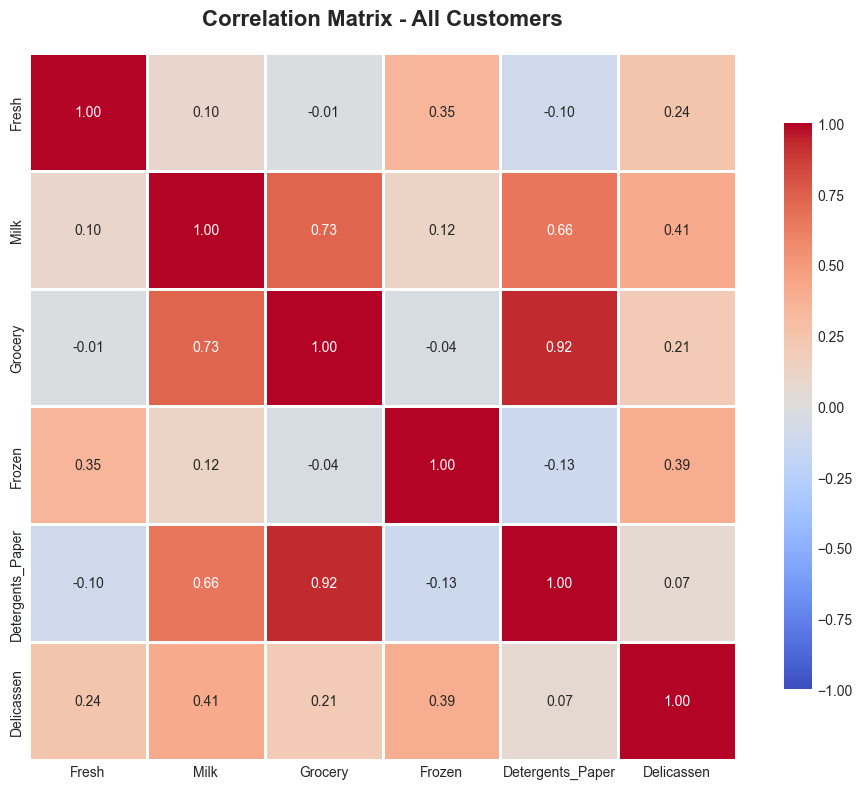


Correlation by Channel:


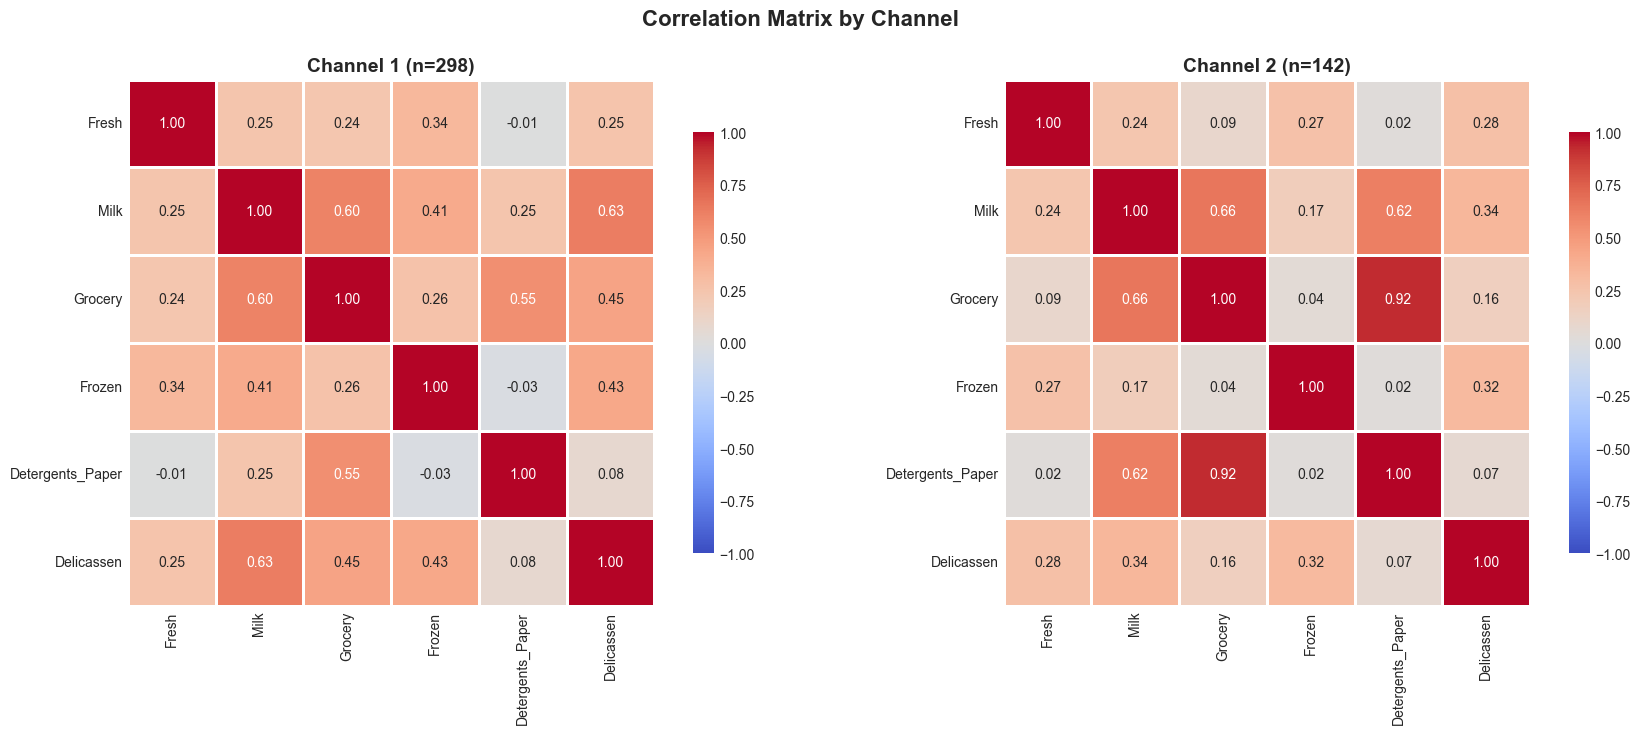


Correlation by Region:


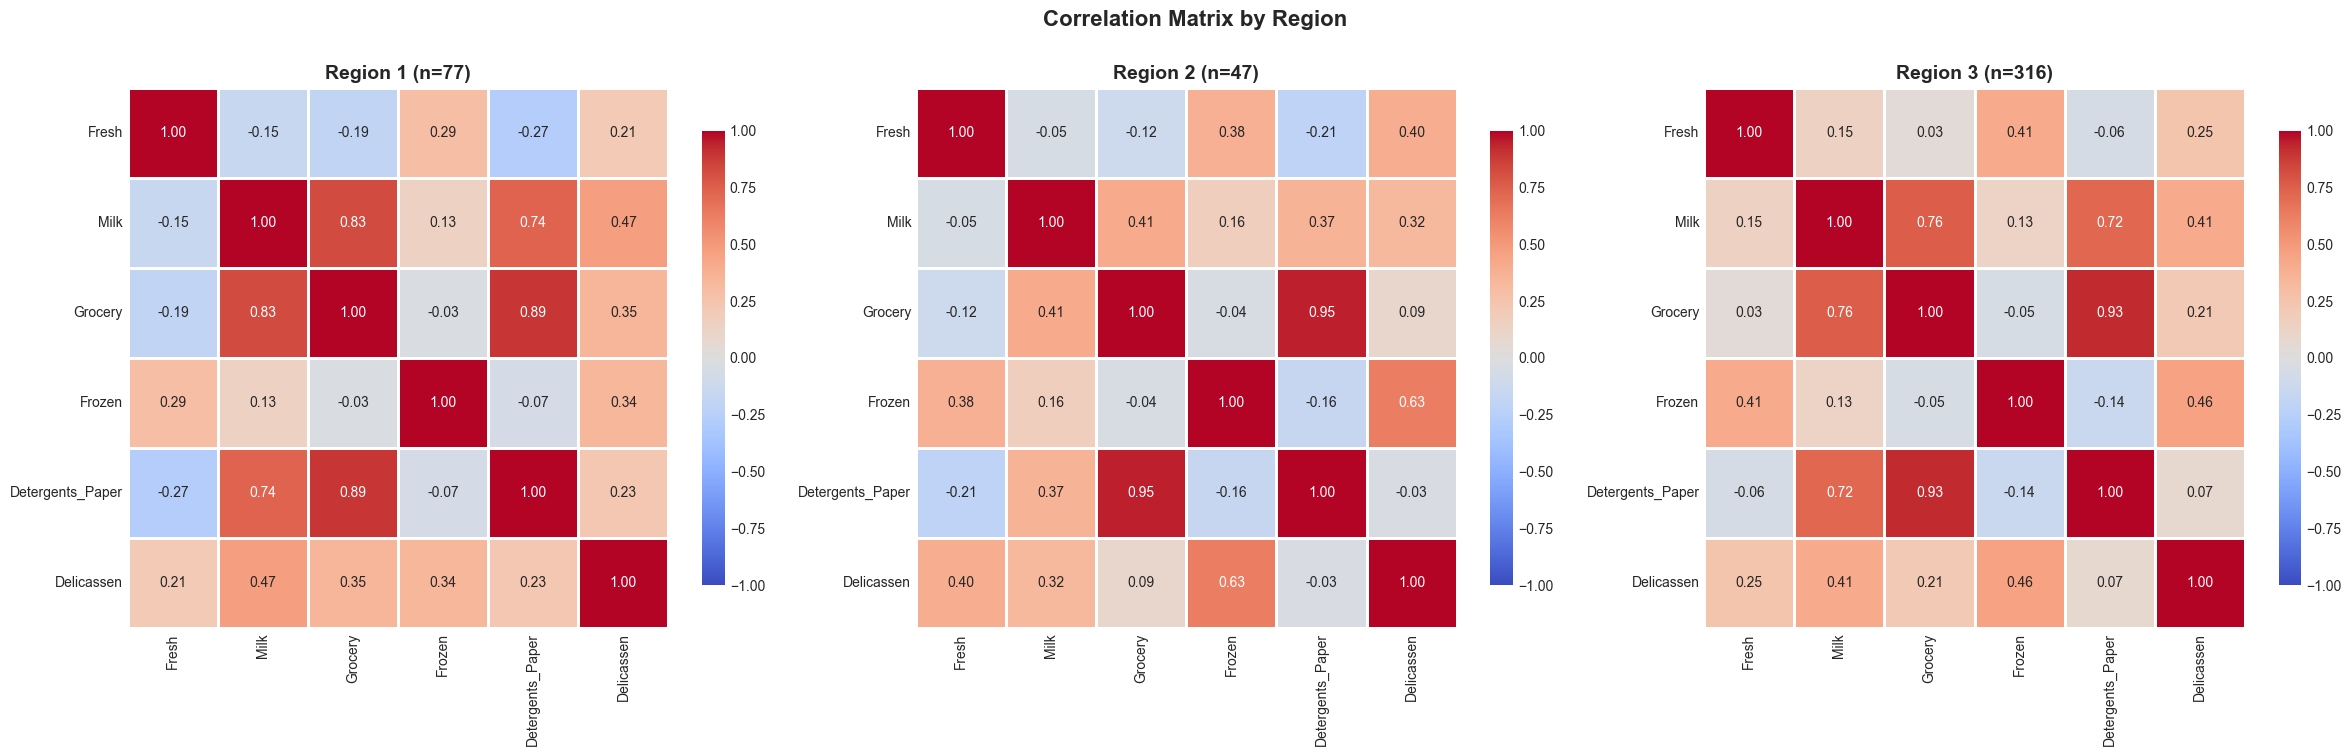


Correlation by Channel & Region:
✓ Saved: correlation_by_channel_region.png


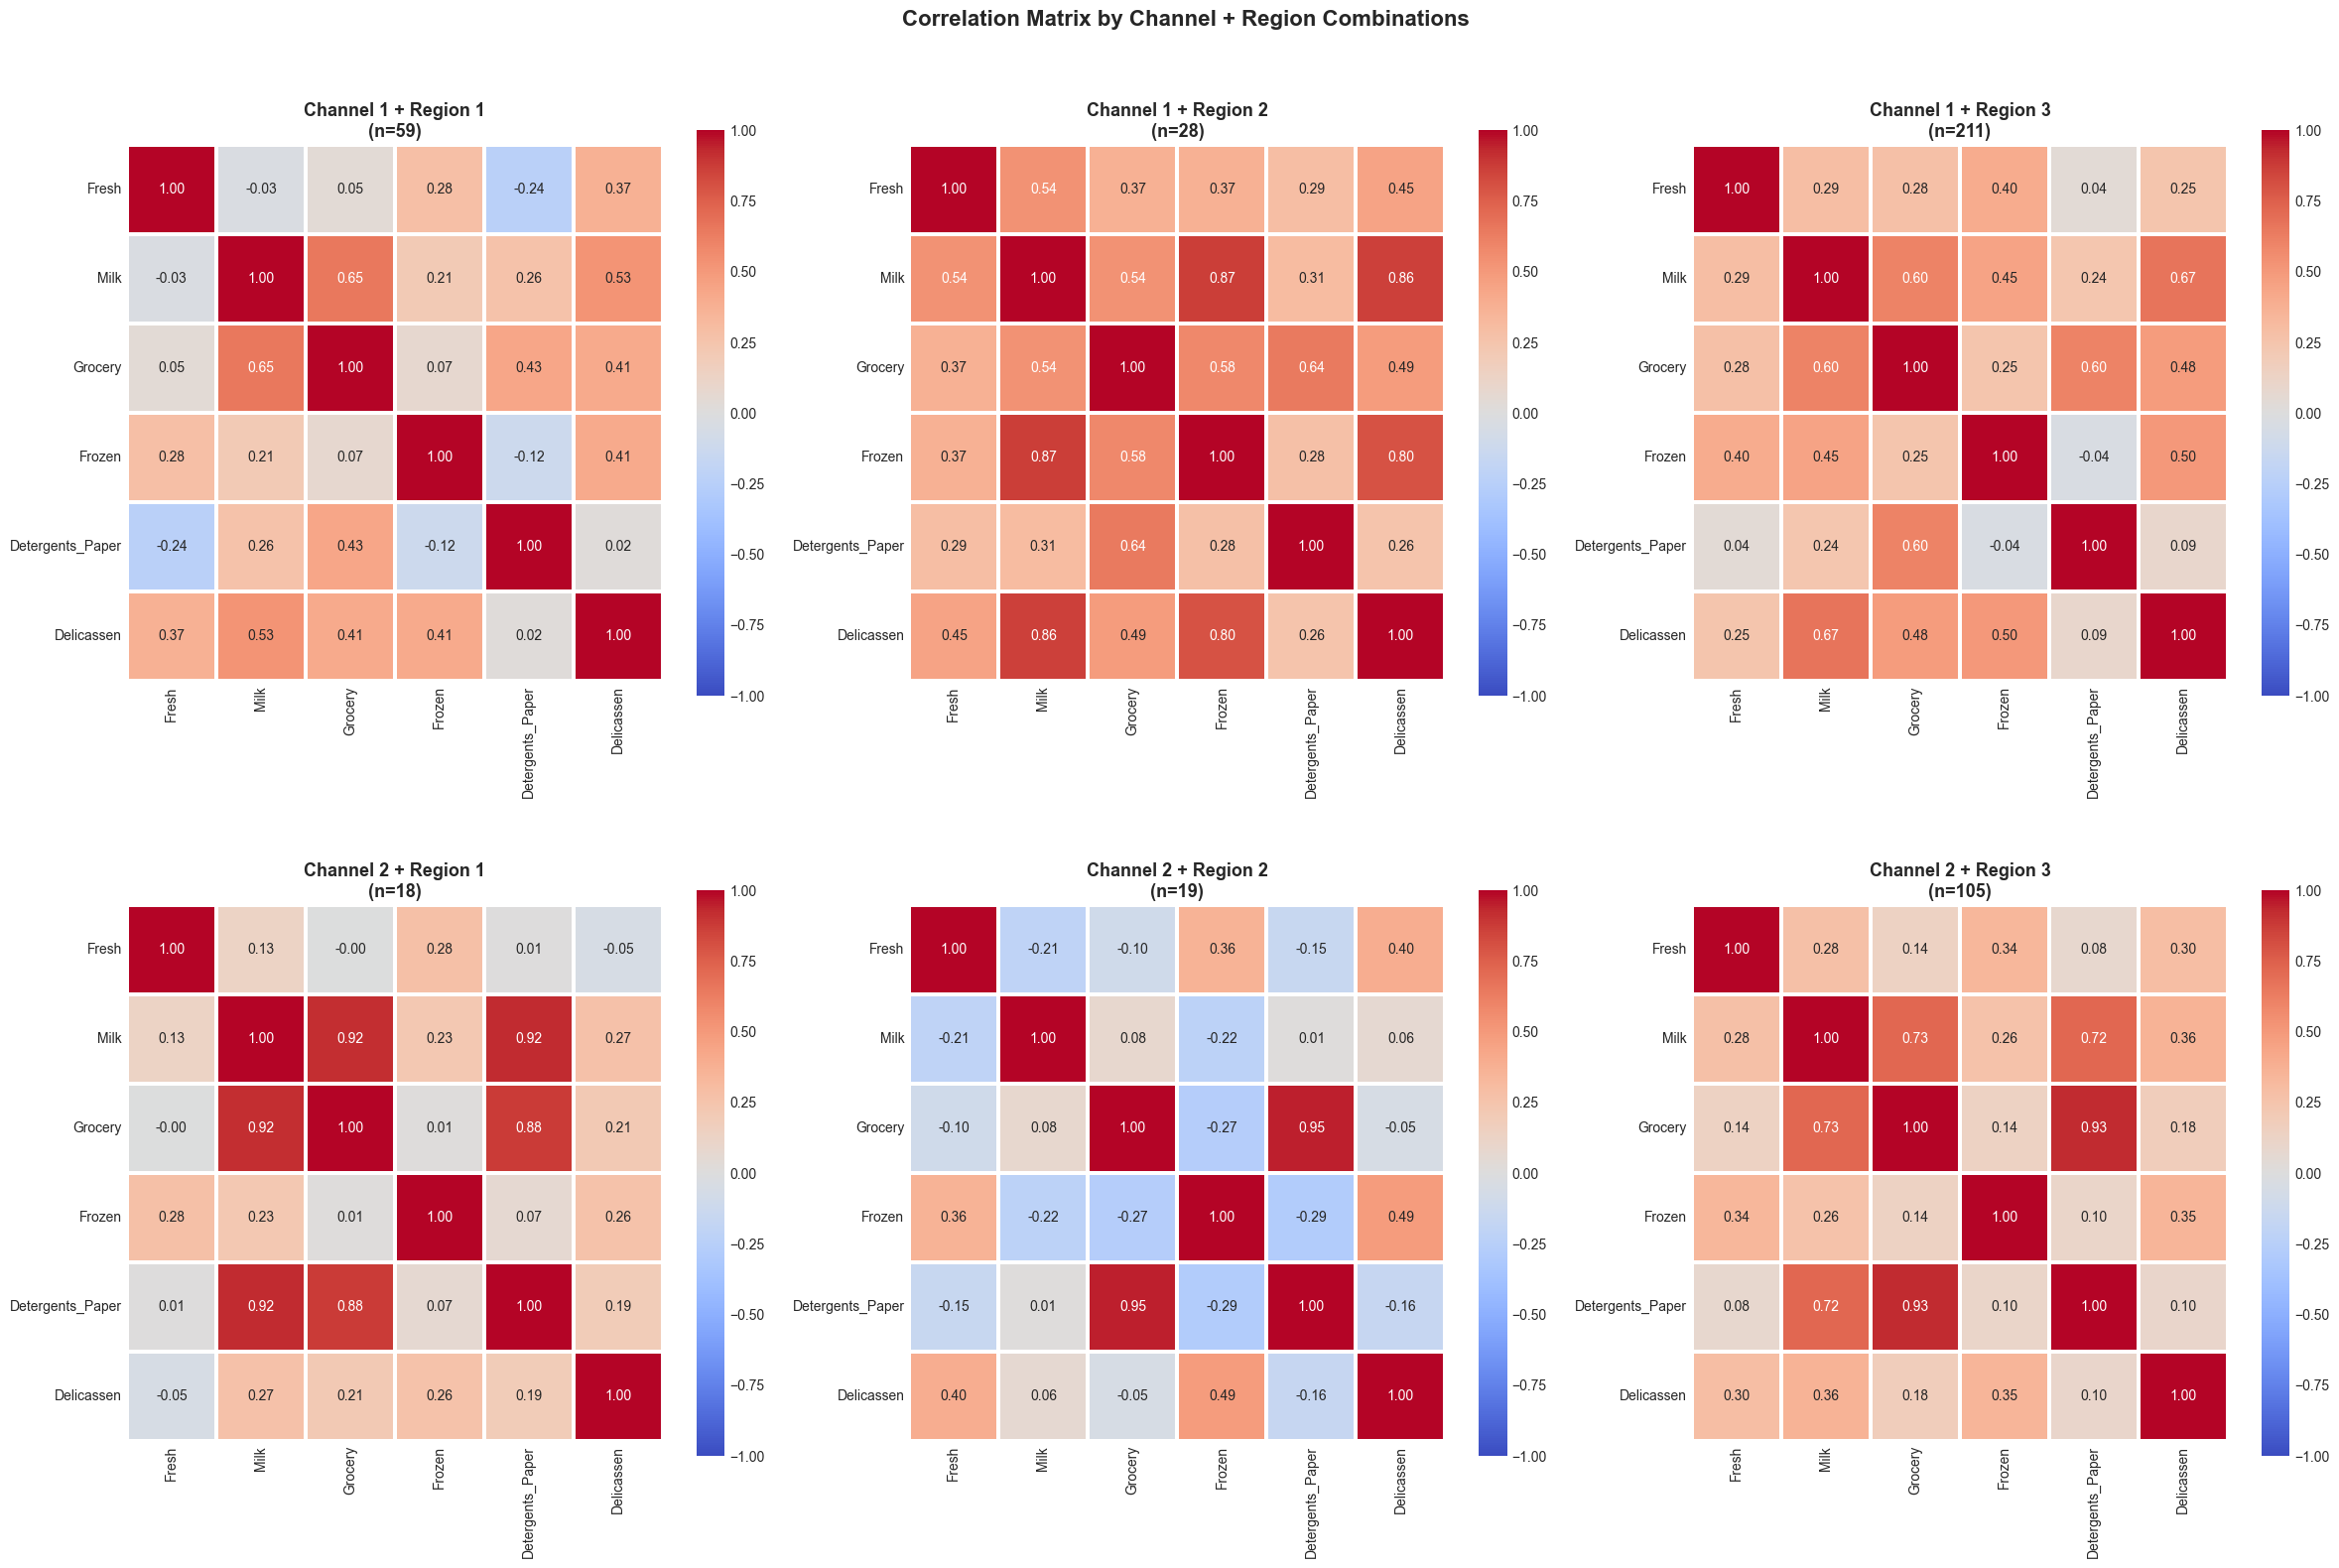

In [34]:
# Correlation Analysis
correlation = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation)

# Find high correlations
print("\nHighly Correlated Pairs (|r| > 0.6):")
threshold = 0.6
found_high_corr = False
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > threshold:
            print(f"  {correlation.columns[i]} <-> {correlation.columns[j]}: {correlation.iloc[i, j]:.3f}")
            found_high_corr = True

if not found_high_corr:
    print("  No pairs with |correlation| > 0.6")

# Overall Correlation Heatmap
print("\nOverall Correlation Heatmap:")
plt.figure(figsize=(10, 8))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix - All Customers', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/correlation_overall.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation by Channel
print("\nCorrelation by Channel:")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, channel in enumerate([1, 2]):
    df_channel = df[df['Channel'] == channel]
    corr_channel = df_channel[numerical_cols].corr()
    
    sns.heatmap(corr_channel, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=2, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Channel {channel} (n={len(df_channel)})', 
                       fontsize=14, fontweight='bold')

plt.suptitle('Correlation Matrix by Channel', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/correlation_by_channel.png', dpi=300, bbox_inches='tight')
plt.show()


# Correlation by Region
print("\nCorrelation by Region:")
regions = sorted(df['Region'].unique())
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for idx, region in enumerate(regions):
    df_region = df[df['Region'] == region]
    corr_region = df_region[numerical_cols].corr()
    
    sns.heatmap(corr_region, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=2, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Region {region} (n={len(df_region)})', 
                       fontsize=14, fontweight='bold')

plt.suptitle('Correlation Matrix by Region', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/correlation_by_region.png', dpi=300, bbox_inches='tight')
plt.show()


# Correlation - Channel & Region Combined
print("\nCorrelation by Channel & Region:")
combinations = []
for channel in sorted(df['Channel'].unique()):
    for region in sorted(df['Region'].unique()):
        subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
        if len(subset) >= 10:  # Only include if we have at least 10 samples
            combinations.append((channel, region, len(subset)))

n_combinations = len(combinations)
n_cols = 3
n_rows = (n_combinations + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8*n_rows))
axes = axes.flatten() if n_combinations > 1 else [axes]

for idx, (channel, region, count) in enumerate(combinations):
    df_subset = df[(df['Channel'] == channel) & (df['Region'] == region)]
    corr_subset = df_subset[numerical_cols].corr()
    
    sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=1.5, ax=axes[idx],
                vmin=-1, vmax=1, center=0, cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'Channel {channel} + Region {region}\n(n={count})', 
                       fontsize=13, fontweight='bold')

# Hide any unused subplots
for idx in range(n_combinations, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Correlation Matrix by Channel + Region Combinations', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/correlation_by_channel_region.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_by_channel_region.png")
plt.show()

### Key Findings from Correlation Analysis

1. Overall Pattern (All Customers)

    - Grocery <> Detergents_Paper: 0.92 (VERY strong! Almost moving together)
    - Milk <> Grocery: 0.73
    - Milk <> Detergents_Paper: 0.66

2. Channel Differences
    - Channel 1 (Hotels/Restaurants - 298 customers):
        - Weaker Grocery <> Detergents correlation (0.55 vs 0.92 in Channel 2)
        - Strong Milk<>Delicassen (0.63) - unique to this channel!

    - Channel 2 (Retail - 142 customers):
        - Extremely strong Grocery <> Detergents (0.92)
        - Typical retail shopping pattern

3. Regional Variations
    - Region 2 shows Frozen <> Delicassen correlation (0.63)
    - All regions maintain strong Grocery <> Detergents correlation

4. Most Interesting Combo: Channel 1 + Region 2 (28 customers)
    - Milk-Frozen: 0.87
    - Milk-Delicassen: 0.86
    - Frozen-Delicassen: 0.80
    - This is a VERY distinct customer group!

5. Implications for My Clustering:
    Should I segment by Channel/Region first?
    - Pros:
        - Very different correlation patterns suggest different customer behaviors
        - Channel 1 + Region 2 is clearly unique (might get lost in overall clustering)
        - More interpretable segments (e.g., "Region 3 Retailers")

    - Cons:
        - Smaller sample sizes (Channel 2 + Region 1 = only 18 customers)
        - More complex analysis
        - Might over-segment

6. My Plan Options:
    - Option A: Cluster overall first, then analyze if clusters align with Channel/Region
    - Option B: Create separate models for Channel 1 vs Channel 2 (strong enough difference)
    - Option C: Add Channel/Region as features in clustering (one-hot encoded)

In [19]:
# Channel & Region Analysis

print("\nAverage Spending by Channel:")
channel_spending = df.groupby('Channel')[numerical_cols].mean()
print(channel_spending)

print("\nAverage Spending by Region:")
region_spending = df.groupby('Region')[numerical_cols].mean()
print(region_spending)


Average Spending by Channel:
                Fresh          Milk       Grocery       Frozen  \
Channel                                                          
1        13475.560403   3451.724832   3962.137584  3748.251678   
2         8904.323944  10716.500000  16322.852113  1652.612676   

         Detergents_Paper   Delicassen  
Channel                                 
1              790.560403  1415.956376  
2             7269.507042  1753.436620  

Average Spending by Region:
               Fresh         Milk      Grocery       Frozen  Detergents_Paper  \
Region                                                                          
1       11101.727273  5486.415584  7403.077922  3000.337662       2651.116883   
2        9887.680851  5088.170213  9218.595745  4045.361702       3687.468085   
3       12533.471519  5977.085443  7896.363924  2944.594937       2817.753165   

         Delicassen  
Region               
1       1354.896104  
2       1159.702128  
3       1620.60126

In [20]:
# Total Spend

df['Total_Spend'] = df[numerical_cols].sum(axis=1)

print(f"\nTotal Spending Statistics:")
print(f"  Mean: ${df['Total_Spend'].mean():,.0f}")
print(f"  Median: ${df['Total_Spend'].median():,.0f}")
print(f"  Std Dev: ${df['Total_Spend'].std():,.0f}")
print(f"  Min: ${df['Total_Spend'].min():,.0f}")
print(f"  Max: ${df['Total_Spend'].max():,.0f}")


Total Spending Statistics:
  Mean: $33,226
  Median: $27,492
  Std Dev: $26,356
  Min: $904
  Max: $199,891


In [24]:
# Findings

avg_spending = df[numerical_cols].mean().sort_values(ascending=False)

print("\n1. DATA QUALITY:")
print(f"   • Total customers: {len(df)}")
print(f"   • No missing values")
print(f"   • No duplicates")

print("\n2. DISTRIBUTION:")
print("   • All features are right-skewed (positive skewness)")
print("   • Significant outliers present in most categories")
print("   • Large variance in spending patterns")

print("\n3. CHANNEL DISTRIBUTION:")
print(f"   • Channel 1: {(df['Channel']==1).sum()} customers ({(df['Channel']==1).sum()/len(df)*100:.1f}%)")
print(f"   • Channel 2: {(df['Channel']==2).sum()} customers ({(df['Channel']==2).sum()/len(df)*100:.1f}%)")

print("\n4. SPENDING PATTERNS:")
print(f"   • Highest avg spending: {avg_spending.index[0]} (${avg_spending.values[0]:,.0f})")
print(f"   • Lowest avg spending: {avg_spending.index[-1]} (${avg_spending.values[-1]:,.0f})")
print(f"   • Average total spending: ${df['Total_Spend'].mean():,.0f}")


1. DATA QUALITY:
   • Total customers: 440
   • No missing values
   • No duplicates

2. DISTRIBUTION:
   • All features are right-skewed (positive skewness)
   • Significant outliers present in most categories
   • Large variance in spending patterns

3. CHANNEL DISTRIBUTION:
   • Channel 1: 298 customers (67.7%)
   • Channel 2: 142 customers (32.3%)

4. SPENDING PATTERNS:
   • Highest avg spending: Fresh ($12,000)
   • Lowest avg spending: Delicassen ($1,525)
   • Average total spending: $33,226
